## Importing libraries and dependencies

In [2]:
!gsutil -m cp gs://dtire-special-storage/archive.zip .
!ls -l

Copying gs://dtire-special-storage/archive.zip...
- [1/1 files][707.6 MiB/707.6 MiB] 100% Done  38.6 MiB/s ETA 00:00:00           
Operation completed over 1 objects/707.6 MiB.                                    
total 724612
-rw-r--r-- 1 root root 741994332 May 20 11:42 archive.zip
drwxr-xr-x 1 root root      4096 May 17 13:39 sample_data


In [3]:
!unzip archive.zip

Archive:  archive.zip
  inflating: Tire Textures/testing_data/cracked/Cracked-1.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-10.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-105.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-11.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-13.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-14.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-15.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-19.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-2.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-20.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-208.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-21.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-22.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-25.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-26.jpg  
  i

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

# HyperParameter


In [5]:
train_path='./Tire Textures/training_data'
test_path='./Tire Textures/testing_data'
EPOCHS=13
BATCH_SIZE=20
RANDOM_SEED=16

# Data visualization

In [6]:
labels=os.listdir(train_path)
labels

['cracked', 'normal']

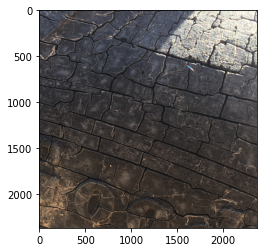

In [7]:
train_cracked=train_path+"/cracked/"
train_normal=train_path+"/normal/"
len(os.listdir(train_cracked))
random_num=np.random.randint(0,len(os.listdir(train_cracked)))
pic_path=os.listdir(train_cracked)[random_num]

img_path=train_cracked + pic_path
plt.imshow(plt.imread(img_path))

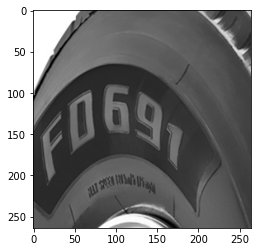

In [8]:
train_normal=train_path+"/normal/"
len(os.listdir(train_normal))
random_num=np.random.randint(0,len(os.listdir(train_normal)))
pic_path=os.listdir(train_normal)[random_num]

img_path=train_normal + pic_path
plt.imshow(plt.imread(img_path))

# Preparing our dataset

In [9]:
def process(data):
    path=Path(data) #get the path
    filepaths=list(path.glob(r"*/*.jpg")) # get all the subpath
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths)) #get the label for each subpath
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1) # concat the series of filepaths and label to be one dataframe
    return df

In [58]:
train=process(train_path)
test=process(test_path)

# merge the dataset
df_full = pd.concat([train, test], axis=0)
df_full = df_full.sample(frac=1, random_state=RANDOM_SEED)

# split the full dataset by 0.8/0.2 to train and test
sliceIdx= int(0.8*len(df_full))
df_train = df_full.iloc[:sliceIdx,:]
df_test_full = df_full.iloc[sliceIdx:,:]

# split the test dataset to val and test
sliceIdx= int(0.5*len(df_test_full))
df_test = df_test_full.iloc[:sliceIdx,:]
df_val = df_test_full.iloc[sliceIdx:,:]

print(df_train.shape)
print(df_val.shape)
print(df_test['labels'].value_counts()['cracked'])
print(df_test.shape)


(822, 2)
(103, 2)
54
(103, 2)


In [59]:
train_generator = ImageDataGenerator( preprocessing_function=preprocess_input, rotation_range = 10, horizontal_flip=True)
val_generator = ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator( preprocessing_function=preprocess_input)

In [60]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                target_size=(224,224),
                                                batch_size=BATCH_SIZE,                                               
                                                random_seed=RANDOM_SEED)

val_image=train_generator.flow_from_dataframe(dataframe=df_val,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                target_size=(224,224),
                                                batch_size=BATCH_SIZE,  
                                                                                             
                                                random_seed=RANDOM_SEED)

test_image = test_generator.flow_from_dataframe(
                                                dataframe=df_test,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                target_size=(224,224),
                                                batch_size=BATCH_SIZE,
                                                random_seed=RANDOM_SEED
)

Found 822 validated image filenames belonging to 2 classes.
Found 103 validated image filenames belonging to 2 classes.
Found 103 validated image filenames belonging to 2 classes.


# Model building

In [61]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False #We don't want to train again the resnet



In [62]:
inputs = pretrained_model.input


x = Dense(152, activation='relu')(pretrained_model.output)
x = Dense(64, activation='relu')(x)#adding some custom layers of our coice

outputs = Dense(1, activation='sigmoid')(x)
#output choice
model = Model(inputs=inputs, outputs=outputs)

In [63]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training

In [64]:
mo_fit=model.fit(train_image,
                 epochs=EPOCHS,
                 validation_data=val_image,
                 verbose = 1)

Epoch 1/13
42/42 [==============================] - 56s 1s/step - loss: 0.9111 - accuracy: 0.7968 - val_loss: 0.2201 - val_accuracy: 0.8932
Epoch 2/13
42/42 [==============================] - 49s 1s/step - loss: 0.4183 - accuracy: 0.8491 - val_loss: 0.2241 - val_accuracy: 0.8835
Epoch 3/13
42/42 [==============================] - 49s 1s/step - loss: 0.2315 - accuracy: 0.8978 - val_loss: 0.1258 - val_accuracy: 0.9612
Epoch 4/13
42/42 [==============================] - 49s 1s/step - loss: 0.1753 - accuracy: 0.9209 - val_loss: 0.1117 - val_accuracy: 0.9612
Epoch 5/13
42/42 [==============================] - 50s 1s/step - loss: 0.1230 - accuracy: 0.9538 - val_loss: 0.1262 - val_accuracy: 0.9320
Epoch 6/13
42/42 [==============================] - 49s 1s/step - loss: 0.0942 - accuracy: 0.9659 - val_loss: 0.1732 - val_accuracy: 0.9320
Epoch 7/13
42/42 [==============================] - 50s 1s/step - loss: 0.0716 - accuracy: 0.9720 - val_loss: 0.1201 - val_accuracy: 0.9515
Epoch 8/13
42/42 [==

# Performance plots

No handles with labels found to put in legend.


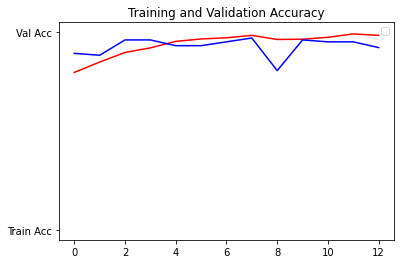

No handles with labels found to put in legend.


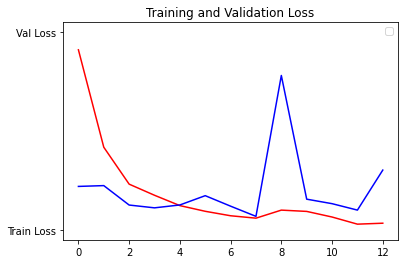

In [65]:
acc = mo_fit.history['accuracy']
val_acc = mo_fit.history['val_accuracy']
loss = mo_fit.history['loss']
val_loss = mo_fit.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', 'Train Acc')
plt.plot(epochs, val_acc, 'b', 'Val Acc')
plt.title("Training and Validation Accuracy")
plt.legend(loc=0)
plt.show()
print('')
plt.plot(epochs, loss, 'r', 'Train Loss')
plt.plot(epochs, val_loss, 'b', 'Val Loss')
plt.legend(loc=0)
plt.title("Training and Validation Loss")
plt.show()

# Evaluation on test set

In [66]:
model.evaluate(test_image)

6/6 [==============================] - 5s 751ms/step - loss: 0.2984 - accuracy: 0.9417


[0.2983538508415222, 0.9417475461959839]